In [7]:
from numpy import *
from matplotlib.pylab import *
import random
import sys
import io
import os
import glob
import h5py

import IPython

#from pydub import AudioSegment
from td_utils import *

In [8]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Concatenate
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.layers import MaxPooling2D, MaxPooling3D, AveragePooling2D, AveragePooling3D
from keras.layers import Conv2D,Conv3D, Lambda
from keras.backend import transpose
from keras.optimizers import Adam
from keras import regularizers

Using TensorFlow backend.


(10, 10, 4000)


<Figure size 432x288 with 0 Axes>

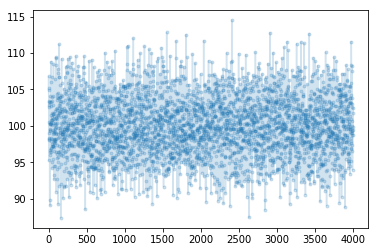

<Figure size 432x288 with 0 Axes>

In [9]:
i = randint(0,900)
home = "/export/home1/users/bssn/serna"
datadir = home+"/SyntheticData/syndat/"
Ft = load(datadir+"d"+str(i).zfill(4)+".npy")

Ftsh = Ft.shape
width,height,T = Ftsh  
print(Ftsh)
t = arange(Ftsh[-1])
figure()
plot(t,sum(sum(Ft,axis=0),axis=0),'.-',alpha=0.2)
figure()

In [10]:
def get_random_time_segment(segment_frames,total_frames=12000):
    '''
    Gets a random time segment of duration segment_frames in a file
    with number of frames: total_frames
    '''
    
    segment_start = randint(0, high = total_frames-
                                   segment_frames)
    segment_end = segment_start + segment_frames
    
    return (segment_start, segment_end)

In [11]:
def is_overlapping(segment_time, previous_segments):
    '''
    This function checks if the time of a segment overlaps with the
    existing segments.
    '''
    s_start, s_end = segment_time
    
    overlap = False
    
    for prev_start, prev_end in previous_segments:
        if s_start <= prev_end and s_end >= prev_start:
            overlap = True
    
    return overlap

## Loading data set.

This is a big dataset, so we are going to divide it in 4000 samples for  training set and 100 dev_set and 100 test_set.

In [12]:
from scipy.fftpack import fft2,fftshift,ifftshift,ifft2

def ftaugment(img,magn=2):
    sh = img.shape
    sh2 = (sh*(magn-1))
    sh2 = ((sh2[0])//2,(sh2[1])//2)
    fftim  = fftshift(fft2(img))
    fftim  =  pad(fftim,(sh2[0],sh2[1]),'constant')    
    imgn = real(ifft2(ifftshift(fftim)))
    return(imgn)

def ftvaugment(img,magn=2):
    sh = img.shape
    sh2 = (sh*(magn-1))
    sh2 = ((sh2[0])//2,(sh2[0])//2)
    fftim  = fftshift(fft2(img,axes=(0,1)),axes=(0,1))
    fftim  =  pad(fftim,(sh2[0],sh2[1]),'constant')    
    imgn = real(ifft2(ifftshift(fftim,axes=(0,1)),axes=(0,1)))
    imgn = imgn[:,:,sh2[0]:-sh2[0]]
    return(imgn)

95


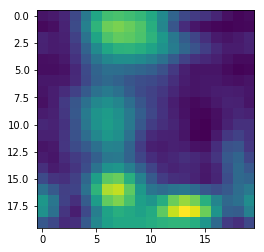

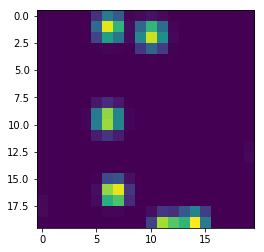

In [31]:
nframes = 500

i = 5
xt = load(datadir+"d"+str(i).zfill(4)+".npy")
yt = load(datadir+"o2_"+str(i).zfill(4)+".npy") 
xt = xt/mean(xt.flatten())
xt = ftvaugment(xt,magn)
ymax = max(1,max(yt.flatten()))
yt = yt

start,end = get_random_time_segment(nframes,T)

ytr = 0.05*ymax*randn(magn*width,magn*height)
colors = array(['C0','C1'])
t = arange(1000)
# We plot some random pieces we chose to fit the network!

i = randint(0,800)
imshow(sum(xt,axis=-1))
figure()
imshow(yt[:])
print(i)

In [32]:
def MOC(y_true,y_pred):
    '''Just another crossentropy'''
    ly =sum(y_true*y_pred)
    ly2 = sum(y_pred*y_pred)
    ly3 = sum(y_true*y_true)
    out = ly/sqrt(ly2*ly3)
    return out


In [62]:
ytr1 = 0.05*ymax*randn(magn*width,magn*height)
ytr2 = 0.05*ymax*randn(magn*width,magn*height)

MOC((1.0*yt+ytr1)/ymax,(1.0*yt+ytr2)/ymax)

0.9255292408051878

In [26]:
yt

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [ ]:
from IPython.lib import backgroundjobs as bg
jobs = bg.BackgroundJobManager()
jobs.new('run_loop()')

In [2]:
import os

In [6]:
import subprocess


p = subprocess.Popen('./generatemore.sh')

for i in range(10):
    print(i)
    
p.wait()
for i in range(10):
    print(i)


0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
